LOADING DATASETS
1. Anthropometric data: (444400, 18)
2. Clinical data: (351701, 29)
3. Dietary data: (234293, 75)
4. Socioeconomic data: (654425, 20)

MERGING DATASETS
Merged Data: (175899, 136)

DROPPING ROWS WITH NO FBS VALUES
Before Cleaning
   Total rows: 175899
   Missing FBS values: 101895

After Cleaning
   Total rows: 74004
   Missing FBS values: 0

REMOVING DUPLICATE COLUMNS
Administrative/Duplicate Columns to be removed (26):
                           
0                     hhnum
1               member_code
2          regcode_clinical
3          provhuc_clinical
4        enns_year_clinical
5   fwgti_natl_var_clinical
6       fwgti_prov_clinical
7         rep_natl_clinical
8         rep_prov_clinical
9       ms_psucode_clinical
10           regcode_anthro
11           provhuc_anthro
12         enns_year_anthro
13    fwgti_natl_var_anthro
14        fwgti_prov_anthro
15          rep_natl_anthro
16          rep_prov_anthro
17        ms_psucode_anthro
18  fwgti_natl2_var_dietary

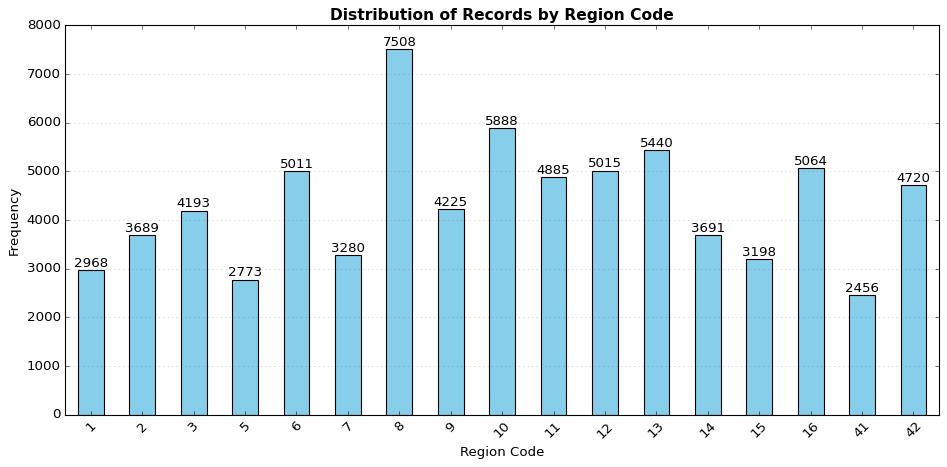

In [16]:
# IMPORT LIBRARIES
##################

import pandas as pd
import numpy as np
import warnings
import os
import matplotlib.pyplot as plt
import torch
import lime
import lime.lime_tabular
import joblib

warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from scipy.stats import skew
from collections import defaultdict
from collections import Counter
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import precision_score, recall_score, fbeta_score, average_precision_score
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# DATA LOADING
##############

print("LOADING DATASETS")
print("="*50)

anthro_data = pd.read_csv('anthro_data.csv')
clinical_data = pd.read_csv('clinical_data.csv')
dietary_data = pd.read_csv('dietary_data.csv')
socio_data = pd.read_csv('socio_data.csv')

print(f"1. Anthropometric data: {anthro_data.shape}")
print(f"2. Clinical data: {clinical_data.shape}")
print(f"3. Dietary data: {dietary_data.shape}")
print(f"4. Socioeconomic data: {socio_data.shape}")

# MERGING DATASETS
##################

print("\nMERGING DATASETS")
print("="*50)

# Merge on both hhnum and member_code
merged_data = pd.merge(
    clinical_data,
    anthro_data,
    on=['hhnum', 'member_code'],
    how='inner',
    suffixes=('_clinical', '_anthro')
)

merged_data = pd.merge(
    merged_data,
    dietary_data,
    on=['hhnum', 'member_code'],
    how='inner',
    suffixes=('', '_dietary')
)

merged_data = pd.merge(
    merged_data,
    socio_data,
    on=['hhnum', 'member_code'],
    how='inner',
    suffixes=('', '_socio')
)
print(f"Merged Data: {merged_data.shape}")

# ROW FILTERING
###############

# Dropping rows with no FBS values
print("\nDROPPING ROWS WITH NO FBS VALUES")
print("="*50)

# Check FBS column status
print("Before Cleaning")
print(f"   Total rows: {len(merged_data)}")
print(f"   Missing FBS values: {merged_data['fbs'].isna().sum()}")

# Drop rows with missing FBS values
merged_data = merged_data.dropna(subset=['fbs'])
print("\nAfter Cleaning")
print(f"   Total rows: {len(merged_data)}")
print(f"   Missing FBS values: {merged_data['fbs'].isna().sum()}")

# COLUMN FILTERING
##################

print("\nREMOVING DUPLICATE COLUMNS")
print("="*50)

admin_columns = ['hhnum', 'member_code']

# Identify duplicate columns based on suffixes
duplicate_cols = []
for col in merged_data.columns:
    for suffix in ['_clinical', '_anthro', '_dietary', '_socio']:
        if col.endswith(suffix):
            duplicate_cols.append(col)

# Drop only the columns that actually exist
all_cols_to_drop = admin_columns + duplicate_cols
existing_cols_to_drop = [col for col in all_cols_to_drop if col in merged_data.columns]

# Display columns to be removed (admin/duplicates) in a table
admin_drop_df = pd.DataFrame({'': existing_cols_to_drop})
print(f"Administrative/Duplicate Columns to be removed ({len(existing_cols_to_drop)}):")

print(admin_drop_df)

# Drop them
merged_data = merged_data.drop(columns=existing_cols_to_drop, errors='ignore')

# Analyze missing values before dropping
missing_summary = pd.DataFrame({
    'Column': merged_data.columns,
    'Missing_Count': merged_data.isnull().sum(),
    'Missing_Percentage': (merged_data.isnull().sum() / len(merged_data)) * 100
}).sort_values('Missing_Percentage', ascending=False)

# Display columns with >50% missing
high_missing = missing_summary[missing_summary['Missing_Percentage'] > 50]
print(f"\nColumns with >50% missing values ({len(high_missing)}):")
print(high_missing[['Column', 'Missing_Percentage']])

# Drop these columns
columns_to_drop = high_missing['Column'].tolist()
merged_data = merged_data.drop(columns=columns_to_drop)

total_dropped = len(existing_cols_to_drop) + len(columns_to_drop)
print(f"\nDropped {(total_dropped)} columns")
print(f"Merged Data: {merged_data.shape}")

# Create main directory
os.makedirs('data_splits/merged', exist_ok=True)

# Save merged data
output_path = 'data_splits/merged/merged_data.csv'
merged_data.to_csv(output_path, index=False)
print(f"\nSaved cleaned merged data to '{output_path}'")

# GROUP DATA BY REGION
######################

# Group data by region code
print("\nSPLITTING DATA BY REGION")
print("="*50)

# Create main directory
os.makedirs('data_splits/regional', exist_ok=True)

# Get value counts
regcode_freq = merged_data['regcode'].value_counts().sort_index()

# Create a more detailed frequency table
freq_table = pd.DataFrame({
    'Region Code': regcode_freq.index,
    'Frequency': regcode_freq.values,
    'Percentage': (regcode_freq.values / len(merged_data) * 100).round(2)
})

print(freq_table.to_string(index=False))

# Visualization
plt.figure(figsize=(12, 6))
regcode_freq.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Records by Region Code', fontsize=14, fontweight='bold')
plt.xlabel('Region Code', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(regcode_freq.values):
    plt.text(i, v + 10, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Save each region's data
regional_dir = 'data_splits/regional'
for region_code, group_data in merged_data.groupby('regcode'):
    region_path = os.path.join(regional_dir, f'region_{region_code}')
    os.makedirs(region_path, exist_ok=True)
    output_file = os.path.join(region_path, 'merged.csv')
    group_data.to_csv(output_file, index=False)
    # print(f"Saved {len(group_data)} records for region {region_code} to {output_file}")




SPLITTING DATA BY REGION
Found 17 regions.

REGIONAL DISTRIBUTION IN SPLITS
    Region  Train    Val   Test  Total
0        1   2076    446    446   2968
1        2   2581    554    554   3689
2        3   2935    629    629   4193
3        5   1941    416    416   2773
4        6   3507    752    752   5011
5        7   2295    493    492   3280
6        8   5254   1127   1127   7508
7        9   2957    634    634   4225
8       10   4120    884    884   5888
9       11   3419    733    733   4885
10      12   3509    753    753   5015
11      13   3808    816    816   5440
12      14   2583    554    554   3691
13      15   2238    480    480   3198
14      16   3544    760    760   5064
15      41   1718    369    369   2456
16      42   3304    708    708   4720
17  Merged  51789  11108  11107  74004


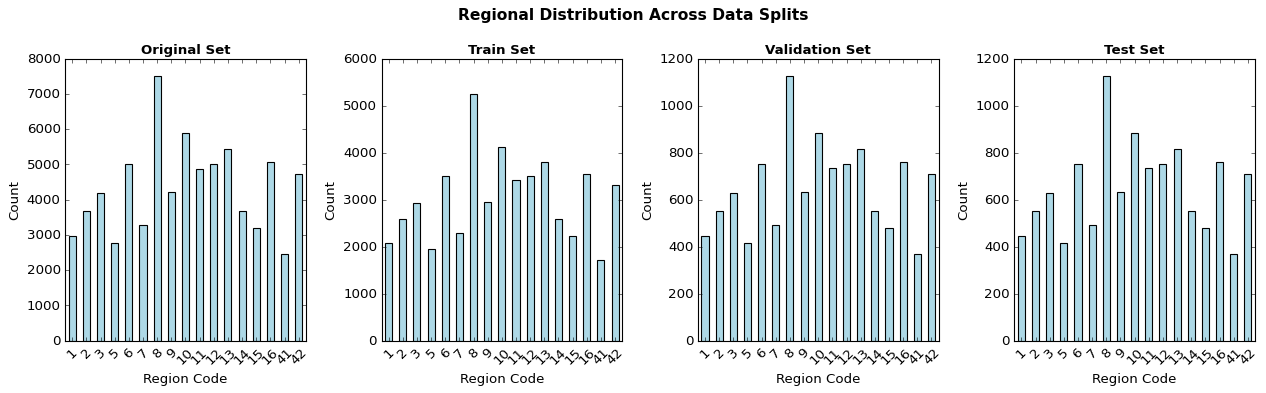

✓ Merged datasets saved to data_splits/merged/
✓ Regional splits saved to data_splits/regional/


In [17]:
# SPLITTING DATA BY REGION (70/15/15)
print("\nSPLITTING DATA BY REGION")
print("="*50)

# CREATE THE GROUPED DATA - ADD THIS SECTION
# Group by regcode
grouped_by_region = merged_data.groupby('regcode')
print(f"Found {grouped_by_region.ngroups} regions.")

# Initialize empty lists to collect splits
train_data_list = []
val_data_list = []
test_data_list = []

# Dictionary to store regional splits
regional_splits = {}

# # Split each region separately
# print("\nSplitting each region into train/val/test sets...")
# print("-"*50)

for regcode, region_data in grouped_by_region:
    # print(f"\nRegion {regcode}:")
    # print(f"  Total samples: {len(region_data)}")
    
    # Create folder for this region
    region_folder = f'data_splits/regional/region_{regcode}'
    os.makedirs(region_folder, exist_ok=True)
    # print(f"  Created folder: {region_folder}/")
    
    # First split: 70% train+val, 15% test
    train_val, test = train_test_split(
        region_data, 
        test_size=0.15, 
        random_state=42,
        shuffle=True
    )
    
    # Second split: from train_val, take 15% for validation
    # 15% of total = 15/85 of train_val
    train, val = train_test_split(
        train_val, 
        test_size=0.15/0.85,  # This gives us 15% of total for validation
        random_state=42,
        shuffle=True
    )
    
    # Verify splits
    train_pct = len(train) / len(region_data) * 100
    val_pct = len(val) / len(region_data) * 100
    test_pct = len(test) / len(region_data) * 100
    
    # print(f"  Train: {len(train)} samples ({train_pct:.1f}%)")
    # print(f"  Val:   {len(val)} samples ({val_pct:.1f}%)")
    # print(f"  Test:  {len(test)} samples ({test_pct:.1f}%)")
    
    # Save as CSV
    train.to_csv(f'{region_folder}/train.csv', index=False)
    val.to_csv(f'{region_folder}/val.csv', index=False)
    test.to_csv(f'{region_folder}/test.csv', index=False)

    # Store in dictionary
    regional_splits[regcode] = {
        'train': train,
        'val': val,
        'test': test
    }
    
    # Add to lists for merging
    train_data_list.append(train)
    val_data_list.append(val)
    test_data_list.append(test)
    
    # print(f"  ✓ Region {regcode} splits saved to {region_folder}/")

# # Combine all regional splits
# print("\nCOMBINING REGIONAL SPLITS")
# print("="*50)

train_data = pd.concat(train_data_list, ignore_index=True)
val_data = pd.concat(val_data_list, ignore_index=True)
test_data = pd.concat(test_data_list, ignore_index=True)

# Shuffle the combined datasets
train_data = train_data.sample(frac=1, random_state=42).reset_index(drop=True)
val_data = val_data.sample(frac=1, random_state=42).reset_index(drop=True)
test_data = test_data.sample(frac=1, random_state=42).reset_index(drop=True)

total_samples = len(train_data) + len(val_data) + len(test_data)
train_pct_overall = len(train_data) / total_samples * 100
val_pct_overall = len(val_data) / total_samples * 100
test_pct_overall = len(test_data) / total_samples * 100

# Check regional distribution in splits
print("\nREGIONAL DISTRIBUTION IN SPLITS")
print("="*50)

# Create distribution comparison
regions = sorted(merged_data['regcode'].unique())

# RECREATE regcode_freq if not defined
regcode_freq = merged_data['regcode'].value_counts().sort_index()

distribution_df = pd.DataFrame({
    'Region': regions,
    'Train': [len(train_data[train_data['regcode'] == r]) for r in regions],
    'Val': [len(val_data[val_data['regcode'] == r]) for r in regions],
    'Test': [len(test_data[test_data['regcode'] == r]) for r in regions],
    'Total': [regcode_freq[r] for r in regions]
})

# Add combined row
combined_row = pd.DataFrame([{
    'Region': 'Merged',
    'Train': len(train_data),
    'Val': len(val_data),
    'Test': len(test_data),
    'Total': total_samples
}])

distribution_df = pd.concat([distribution_df, combined_row], ignore_index=True)
print(distribution_df)

fig, axes = plt.subplots(1, 4, figsize=(16, 5))
datasets = [merged_data, train_data, val_data, test_data]
titles = ['Original', 'Train', 'Validation', 'Test']

for ax, data, title in zip(axes, datasets, titles):
    data['regcode'].value_counts().sort_index().plot(kind='bar', ax=ax, color='lightblue')
    ax.set_title(f'{title} Set', fontsize=12, fontweight='bold')
    ax.set_xlabel('Region Code')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('Regional Distribution Across Data Splits', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Save as CSV
train_data.to_csv('data_splits/merged/train.csv', index=False)
val_data.to_csv('data_splits/merged/val.csv', index=False)
test_data.to_csv('data_splits/merged/test.csv', index=False)

print("✓ Merged datasets saved to data_splits/merged/")
print("✓ Regional splits saved to data_splits/regional/")


In [3]:
import pandas as pd
import numpy as np
import os
from sklearn.impute import KNNImputer, SimpleImputer

def impute_data(df):
    """
    Impute missing values in a DataFrame using appropriate strategies.
    """

    # Convert blank strings or whitespace-only cells to NaN
    df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

    # Drop columns with 100% missing values
    all_missing = df.columns[df.isnull().all()].tolist()
    if all_missing:
        print(f"Dropping {len(all_missing)} columns with 100% missing values: {all_missing}")
        df.drop(columns=all_missing, inplace=True)

    missing_cols = df.columns[df.isnull().any()].tolist()
    columns_to_drop = []
    print("\nNumber of columns with missing values in the dataset: " + str(len(missing_cols)))

    # Classify columns
    categorical_cols, numerical_cols = [], []

    for col in missing_cols:
        if col not in columns_to_drop:
            non_null_values = df[col].dropna()
            unique_count = non_null_values.nunique()
            is_integer = df[col].dtype in ['int64', 'int32'] or (
                df[col].dtype in ['float64', 'float32'] and 
                len(non_null_values) > 0 and 
                (non_null_values == non_null_values.astype(int)).all()
            )
            
            # Classify as categorical or numerical
            if unique_count <= 20 or (is_integer and unique_count <= 50 and (unique_count / len(non_null_values)) < 0.05):
                categorical_cols.append(col)
            else:
                numerical_cols.append(col)

    print(f"Categorical columns to impute: {len(categorical_cols)}")
    print(f"Numerical columns to impute: {len(numerical_cols)}")

    # --- Categorical Imputation ---
    if categorical_cols:
        print(f"\nImputing {len(categorical_cols)} categorical columns with most frequent value...")
        try:
            imp_cat = SimpleImputer(strategy="most_frequent")
            df[categorical_cols] = pd.DataFrame(
                imp_cat.fit_transform(df[categorical_cols]),
                columns=categorical_cols,
                index=df.index
            )
            print("Categorical imputation done.")
        except Exception as e:
            print(f"Error in categorical imputation: {e}")
            print("Falling back to manual mode filling...")
            for col in categorical_cols:
                if df[col].isnull().all():
                    df[col].fillna("Unknown", inplace=True)
                else:
                    mode_val = df[col].mode()[0]
                    df[col].fillna(mode_val, inplace=True)
            print("Categorical imputation done (fallback method).")

    # --- Numerical Imputation ---
    if numerical_cols:
        print(f"\nImputing {len(numerical_cols)} numerical columns with KNN...")
        try:
            imputer = KNNImputer(n_neighbors=5)
            df[numerical_cols] = pd.DataFrame(
                imputer.fit_transform(df[numerical_cols]),
                columns=numerical_cols,
                index=df.index
            )
            print("Numerical imputation done.")
        except Exception as e:
            print(f"Error in KNN imputation: {e}")
            print("Falling back to median filling...")
            for col in numerical_cols:
                if df[col].isnull().all():
                    df[col].fillna(0, inplace=True)
                else:
                    median_val = df[col].median()
                    df[col].fillna(median_val, inplace=True)
            print("Numerical imputation done (fallback method).")
    
    return df

def process_file(input_file, output_file):
    """Read, impute, and write csv file."""
    print("="*50)
    
    try:
        df = pd.read_csv(input_file)

        # Convert blank strings to NaN
        df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

        print(f"Missing values before imputation: {df.isnull().sum().sum()}")
        df = impute_data(df)
        print(f"Missing values after imputation: {df.isnull().sum().sum()}")

        df.to_csv(output_file, index=False)
        print(f"Successfully saved to: {output_file}")
        
    except Exception as e:
        print(f"Error processing {input_file}: {e}")
        raise


# === Main execution ===
try:
    print("PROCESSING MERGED DATASET")
    print("="*60)

    merged_dir = 'data_splits/merged'
    splits = ['train', 'val', 'test']

    for split in splits:
        input_file = os.path.join(merged_dir, f"{split}.csv")
        output_file = os.path.join(merged_dir, f"{split}_imputed.csv")

        if os.path.exists(input_file):
            print(f"\nProcessing merged {split} set")
            process_file(input_file, output_file)

            if os.path.exists(output_file):
                df = pd.read_csv(output_file)

        else:
            print(f"Merged {split} file not found: {input_file}")

    print("\nPROCESSING REGIONAL DATASETS")
    print("="*60)
    
    regional_dir = 'data_splits/regional'
    
    if os.path.exists(regional_dir):
        for region in os.listdir(regional_dir):
            region_path = os.path.join(regional_dir, region)

            if os.path.isdir(region_path):
                for split in ['train', 'val', 'test']:
                    split_file = os.path.join(region_path, f'{split}.csv')
                    output_file = os.path.join(region_path, f'{split}_imputed.csv')

                    if os.path.exists(split_file):
                        print(f"\nProcessing region: {region} ({split})")
                        process_file(split_file, output_file)

                        if os.path.exists(output_file):
                            df = pd.read_csv(output_file)

    else:
        print("Regional directory not found, skipping regional processing")

    print("\n" + "="*60)
    print("IMPUTATION COMPLETE FOR ALL DATASETS")
    print("="*60)

except Exception as e:
    print(f"Fatal error: {e}")
    import traceback
    traceback.print_exc()

PROCESSING MERGED DATASET

Processing merged train set
Missing values before imputation: 104116

Number of columns with missing values in the dataset: 20
Categorical columns to impute: 9
Numerical columns to impute: 11

Imputing 9 categorical columns with most frequent value...
Categorical imputation done.

Imputing 11 numerical columns with KNN...
Numerical imputation done.
Missing values after imputation: 0
Successfully saved to: data_splits/merged\train_imputed.csv

Processing merged val set
Missing values before imputation: 22394

Number of columns with missing values in the dataset: 20
Categorical columns to impute: 9
Numerical columns to impute: 11

Imputing 9 categorical columns with most frequent value...
Categorical imputation done.

Imputing 11 numerical columns with KNN...
Numerical imputation done.
Missing values after imputation: 0
Successfully saved to: data_splits/merged\val_imputed.csv

Processing merged test set
Missing values before imputation: 22454

Number of column

In [ ]:
import os
import pandas as pd
import numpy as np

# Function to apply FBS status classification and create binary version
def apply_fbs_status(df):
    conditions = [
        (df['fbs'] < 100),
        (df['fbs'] >= 100) & (df['fbs'] <= 125),
        (df['fbs'] > 125)
    ]
    status_labels = [0, 1, 2]  # 0: Normal, 1: Prediabetic, 2: Diabetic
    df['fbs_status'] = np.select(conditions, status_labels, default=-1)
    df['fbs_binary'] = df['fbs_status'].apply(lambda x: 1 if x == 2 else 0)
    return df

# Aggregated total summaries
merged_total_3class = {'Normal': 0, 'Prediabetic': 0, 'Diabetic': 0}
merged_total_2class = {'Normal': 0, 'Diabetic': 0}
regional_total_3class = {}
regional_total_2class = {}

print("CREATING TARGET VARIABLE")
print("=" * 80)

# Apply to merged datasets (aggregate totals)
for split in ['train', 'val', 'test']:
    path = f'data_splits/merged/{split}_imputed.csv'
    if os.path.exists(path):
        df = pd.read_csv(path)
        if 'fbs' not in df.columns:
            print(f"'{path}' does not contain 'fbs' column. Skipping.")
            continue

        df = apply_fbs_status(df)
        df.to_csv(path, index=False)

        dist_3 = df['fbs_status'].value_counts().to_dict()
        dist_2 = df['fbs_binary'].value_counts().to_dict()

        merged_total_3class['Normal'] += dist_3.get(0, 0)
        merged_total_3class['Prediabetic'] += dist_3.get(1, 0)
        merged_total_3class['Diabetic'] += dist_3.get(2, 0)

        merged_total_2class['Normal'] += dist_2.get(0, 0)
        merged_total_2class['Diabetic'] += dist_2.get(1, 0)

    else:
        print(f"File not found: {path}")

# Apply to regional datasets (aggregate totals)
regional_dir = 'data_splits/regional'
if os.path.exists(regional_dir):
    for region in sorted(os.listdir(regional_dir)):
        region_path = os.path.join(regional_dir, region)
        total_3 = {'Normal': 0, 'Prediabetic': 0, 'Diabetic': 0}
        total_2 = {'Normal': 0, 'Diabetic': 0}

        for split in ['train', 'val', 'test']:
            file_path = os.path.join(region_path, f'{split}_imputed.csv')
            if os.path.exists(file_path):
                df = pd.read_csv(file_path)
                if 'fbs' not in df.columns:
                    print(f"'{file_path}' missing 'fbs' column. Skipping.")
                    continue

                df = apply_fbs_status(df)
                df.to_csv(file_path, index=False)

                dist_3 = df['fbs_status'].value_counts().to_dict()
                dist_2 = df['fbs_binary'].value_counts().to_dict()

                total_3['Normal'] += dist_3.get(0, 0)
                total_3['Prediabetic'] += dist_3.get(1, 0)
                total_3['Diabetic'] += dist_3.get(2, 0)

                total_2['Normal'] += dist_2.get(0, 0)
                total_2['Diabetic'] += dist_2.get(1, 0)
            else:
                print(f"File not found: {file_path}")

        regional_total_3class[region] = total_3
        regional_total_2class[region] = total_2
else:
    print("Regional directory not found")

print("\nDONE APPLYING FBS STATUS")

# Convert dictionaries to DataFrames for display
merged_total_3class_df = pd.DataFrame.from_dict(merged_total_3class, orient='index', columns=['Count'])
merged_total_2class_df = pd.DataFrame.from_dict(merged_total_2class, orient='index', columns=['Count'])

regional_total_3class_df = pd.DataFrame.from_dict(regional_total_3class, orient='index').reset_index().rename(columns={'index': 'Region'})
regional_total_2class_df = pd.DataFrame.from_dict(regional_total_2class, orient='index').reset_index().rename(columns={'index': 'Region'})

# Display the aggregated tables
print("\nFBS Distribution in Merged Dataset (3 Target Classes)")
print(merged_total_3class_df)

# print("\nFBS Distribution in Merged Dataset (2 Target Classes)")
# print(merged_total_2class_df)

print("\nFBS Distribution per Region (3 Target Classes)")
print(regional_total_3class_df)

# print("\nFBS Distribution per Region (2 Target Classes)")
# print(regional_total_2class_df)


CREATING TARGET VARIABLE

DONE APPLYING FBS STATUS

FBS Distribution in Merged Dataset (3 Target Classes)
             Count
Normal       48439
Prediabetic  19504
Diabetic      6061

FBS Distribution in Merged Dataset (2 Target Classes)
          Count
Normal    67943
Diabetic   6061

FBS Distribution per Region (3 Target Classes)
       Region  Normal  Prediabetic  Diabetic
0    region_1    1568         1070       330
1   region_10    4012         1431       445
2   region_11    3319         1183       383
3   region_12    3395         1183       437
4   region_13    3470         1343       627
5   region_14    2380         1094       217
6   region_15    2405          606       187
7   region_16    3547         1106       411
8    region_2    2321         1138       230
9    region_3    2273         1411       509
10  region_41    1483          729       244
11  region_42    3191         1154       375
12   region_5    1826          768       179
13   region_6    3125         1457   

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

def apply_smote_to_dataset(X, y, dataset_name, random_state=42):
    """
    Apply SMOTE to balance dataset and return balanced data with analysis
    """
    # Ensure X and y are numeric
    if hasattr(X, 'select_dtypes'):
        non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns
        if len(non_numeric_cols) > 0:
            print(f"   Warning: Non-numeric columns found: {list(non_numeric_cols)}")
            return X, y, False, None
    
    # Original distribution
    original_dist = Counter(y)
    
    # Calculate original imbalance ratio
    if len(original_dist) > 1:
        majority_count = max(original_dist.values())
        minority_count = min(original_dist.values())
        original_ratio = majority_count / minority_count
    else:
        print("Only one class found, skipping SMOTE")
        return X, y, False, None
    
    # Check minimum samples per class for SMOTE
    min_samples = min(original_dist.values())
    k_neighbors = min(3, min_samples - 1)
    
    if k_neighbors < 1:
        print(f"Not enough samples for SMOTE (min class has {min_samples} samples)")
        return X, y, False, None
    
    # Apply SMOTE
    try:
        smote = SMOTE(random_state=random_state, k_neighbors=k_neighbors)
        X_resampled, y_resampled = smote.fit_resample(X, y)
        
        # New distribution
        new_dist = Counter(y_resampled)
        
        # Calculate improvement
        total_original = sum(original_dist.values())
        total_new = sum(new_dist.values())
        increase_pct = ((total_new - total_original) / total_original) * 100
        
        return X_resampled, y_resampled, True, {
            'original_dist': original_dist,
            'new_dist': new_dist,
            'original_ratio': original_ratio if len(original_dist) > 1 else 1.0,
            'samples_added': total_new - total_original
        }
        
    except Exception as e:
        print(f"SMOTE failed for {dataset_name}: {str(e)}")
        return X, y, False, None

def save_balanced_dataset(X_resampled, y_resampled, original_columns, output_path, dataset_name):
    """
    Save balanced dataset with proper formatting and original column names
    """
    try:
        # Combine features and target with original column names
        if isinstance(X_resampled, np.ndarray):
            # Convert numpy array back to DataFrame with original column names
            balanced_df = pd.DataFrame(X_resampled, columns=original_columns)
        else:
            balanced_df = X_resampled.copy()
        
        balanced_df['fbs_status'] = y_resampled
        
        # Save to CSV
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        balanced_df.to_csv(output_path, index=False)
        
        return balanced_df
        
    except Exception as e:
        print(f"Error saving balanced dataset: {str(e)}")
        return None

print("STARTING SMOTE BALANCING PROCESS")
print("="*80)

# Store results for summary
smote_results = []

# Process Merged Dataset
try:
    merged_data = pd.read_csv('data_splits/merged/train_imputed.csv')

    # Prepare features and target
    X_merged = merged_data.drop(['fbs_status', 'fbs'], axis=1, errors='ignore')
    y_merged = merged_data['fbs_status']
    
    # Store original column names
    original_columns = X_merged.columns.tolist()
    
    # Remove any rows with invalid target values
    valid_indices = y_merged.isin([0, 1, 2])
    X_merged = X_merged[valid_indices]
    y_merged = y_merged[valid_indices]
    
    print(f"Processing merged dataset - {X_merged.shape}")
    
    # Ensure all data is numeric
    # Drop non-numeric columns and log them
    dropped_cols = list(set(X_merged.columns) - set(X_merged.select_dtypes(include=[np.number]).columns))
    if dropped_cols:
        print(f"Merged Dataset - Dropped non-numeric columns before SMOTE: {dropped_cols}")
    X_merged = X_merged.select_dtypes(include=[np.number])


    # Apply SMOTE
    X_balanced, y_balanced, success, stats = apply_smote_to_dataset(
        X_merged, y_merged, "Merged Dataset"
    )
    
    if success:
        # Update original columns to match the numeric-only dataset
        original_columns = X_merged.columns.tolist()
        
        # Save balanced dataset to the same merged directory
        balanced_df = save_balanced_dataset(
            X_balanced, y_balanced, original_columns,
            'data_splits/merged/train_balanced.csv',
            "Merged Dataset"
        )

        # Store results
        smote_results.append({
            'Dataset': 'Merged',
            'Original_Samples': sum(stats['original_dist'].values()),
            'Balanced_Samples': sum(stats['new_dist'].values()),
            'Samples_Added': stats['samples_added'],
            'Original_Ratio': stats['original_ratio'],
            'Status': 'Success'
        })

except Exception as e:
    print(f"Error processing merged dataset: {str(e)}")
    import traceback
    traceback.print_exc()
    smote_results.append({
        'Dataset': 'Merged',
        'Status': f'Failed: {str(e)}'
    })

# # 2. Process Regional Datasets
regional_dir = 'data_splits/regional'

if os.path.exists(regional_dir):
    for region in sorted(os.listdir(regional_dir)):
        region_path = os.path.join(regional_dir, region)
        train_file = os.path.join(region_path, 'train_imputed.csv')
        
        if os.path.exists(train_file):
            try:
                regional_data = pd.read_csv(train_file)
                
                # Prepare features and target
                X_regional = regional_data.drop(['fbs_status', 'fbs'], axis=1, errors='ignore')
                y_regional = regional_data['fbs_status']
                
                # Remove any rows with invalid target values
                valid_indices = y_regional.isin([0, 1, 2])
                X_regional = X_regional[valid_indices]
                y_regional = y_regional[valid_indices]
                
                print(f"Processing {region} - {X_regional.shape}")
                
                # Check if we have enough samples for SMOTE
                if len(y_regional) < 10:
                    print(f"{region}: Too few samples ({len(y_regional)}) for SMOTE")
                    smote_results.append({
                        'Dataset': region,
                        'Status': 'Skipped: Too few samples'
                    })
                    continue
                
                # Check if we have all classes
                unique_classes = set(y_regional.unique())
                if len(unique_classes) < 2:
                    print(f"{region}: Insufficient class diversity for SMOTE")
                    smote_results.append({
                        'Dataset': region,
                        'Status': 'Skipped: Insufficient class diversity'
                    })
                    continue
                
                # Ensure all data is numeric
                # Drop non-numeric columns and log them
                dropped_cols = list(set(X_regional.columns) - set(X_regional.select_dtypes(include=[np.number]).columns))
                if dropped_cols:
                    print(f"{region} - Dropped non-numeric columns before SMOTE: {dropped_cols}")
                X_regional = X_regional.select_dtypes(include=[np.number])
                original_columns = X_regional.columns.tolist()
                
                # Apply SMOTE
                X_balanced, y_balanced, success, stats = apply_smote_to_dataset(
                    X_regional, y_regional, region
                )
                
                if success:
                    # Save balanced dataset to the same regional directory
                    balanced_df = save_balanced_dataset(
                        X_balanced, y_balanced, original_columns,
                        f'{region_path}/train_balanced.csv',
                        region
                    )
 
                    # Store results
                    smote_results.append({
                        'Dataset': region,
                        'Original_Samples': sum(stats['original_dist'].values()),
                        'Balanced_Samples': sum(stats['new_dist'].values()),
                        'Samples_Added': stats['samples_added'],
                        'Original_Ratio': stats['original_ratio'],
                        'Status': 'Success'
                    })
                else:
                    smote_results.append({
                        'Dataset': region,
                        'Status': 'Failed: SMOTE application failed'
                    })
                
            except Exception as e:
                print(f"Error processing {region}: {str(e)}")
                smote_results.append({
                    'Dataset': region,
                    'Status': f'Failed: {str(e)}'
                })
else:
    print("Regional directory 'data_splits/regional' not found!")


print("\n" + "="*80)
print("SMOTE BALANCING SUMMARY REPORT")
print("="*80)

if smote_results:
    results_df = pd.DataFrame(smote_results)

    # Fill missing numeric columns with NaN for consistent display
    for col in ['Original_Samples', 'Balanced_Samples', 'Samples_Added', 'Original_Ratio']:
        if col not in results_df.columns:
            results_df[col] = None

    # Sort by Dataset for better readability
    results_df = results_df.sort_values('Dataset').reset_index(drop=True)

    # Format numeric values (optional: remove decimals for sample counts)
    results_df['Original_Samples'] = results_df['Original_Samples'].apply(lambda x: f"{int(x):,}" if pd.notnull(x) else "-")
    results_df['Balanced_Samples'] = results_df['Balanced_Samples'].apply(lambda x: f"{int(x):,}" if pd.notnull(x) else "-")
    results_df['Samples_Added'] = results_df['Samples_Added'].apply(lambda x: f"{int(x):,}" if pd.notnull(x) else "-")
    results_df['Original_Ratio'] = results_df['Original_Ratio'].apply(lambda x: f"{x:.2f}:1" if pd.notnull(x) else "-")

    # Reorder columns for presentation
    display_columns = ['Dataset', 'Original_Samples', 'Balanced_Samples', 'Samples_Added', 'Original_Ratio', 'Status']
    results_df = results_df[display_columns]

    print(results_df.to_string(index=False))

    # Optional: Calculate and display overall summary stats
    successful = smote_results_df = pd.DataFrame(smote_results)[pd.DataFrame(smote_results)['Status'] == 'Success']
    if not successful.empty:
        total_original = successful['Original_Samples'].sum()
        total_balanced = successful['Balanced_Samples'].sum()
        total_added = successful['Samples_Added'].sum()

        print(f"\nOVERALL SUMMARY:")
        print(f"   Total original samples: {total_original:,}")
        print(f"   Total balanced samples: {total_balanced:,}")
        print(f"   Total samples added: {total_added:,}")
        print(f"   Overall increase: {(total_added / total_original) * 100:.1f}%")


STARTING SMOTE BALANCING PROCESS
Processing merged dataset - (51789, 107)
Processing region_1 - (2076, 107)
Processing region_10 - (4120, 107)
Processing region_11 - (3419, 107)
Processing region_12 - (3509, 107)
Processing region_13 - (3808, 107)
Processing region_14 - (2583, 103)
Processing region_15 - (2238, 107)
Processing region_16 - (3544, 107)
Processing region_2 - (2581, 103)
Processing region_3 - (2935, 107)
Processing region_41 - (1718, 107)
Processing region_42 - (3304, 107)
Processing region_5 - (1941, 107)
Processing region_6 - (3507, 107)
Processing region_7 - (2295, 107)
Processing region_8 - (5254, 107)
Processing region_9 - (2957, 107)

SMOTE BALANCING SUMMARY REPORT
  Dataset Original_Samples Balanced_Samples Samples_Added Original_Ratio  Status
   Merged           51,789          101,637        49,848         7.91:1 Success
 region_1            2,076            3,237         1,161         4.69:1 Success
region_10            4,120            8,358         4,238       

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import pandas as pd

# Load dataset splits once
train_df = pd.read_csv("data_splits/merged/train_balanced.csv")
val_df = pd.read_csv("data_splits/merged/val_imputed.csv")
test_df  = pd.read_csv("data_splits/merged/test_imputed.csv")

X_train = train_df.drop(columns=['fbs_status','fbs'], errors='ignore')
y_train = train_df['fbs_status']
X_val = val_df.drop(columns=['fbs_status','fbs'], errors='ignore')
y_val = val_df['fbs_status']
X_test  = test_df.drop(columns=['fbs_status','fbs'], errors='ignore')
y_test  = test_df['fbs_status']

# ===== Step 0: Show top 20 strongest feature-target correlations =====
print("\n" + "="*80)
print("TOP 20 STRONGEST FEATURE-TARGET CORRELATIONS (with 'fbs_status')")
print("="*80)

# Combine training data for correlation
train_combined = X_train.copy()
train_combined['fbs_status'] = y_train

# Compute correlation with target
corr_with_target = train_combined.corr()['fbs_status'].drop('fbs_status')
top_corr = corr_with_target.abs().sort_values(ascending=False).head(20)

# Display
correlation_df = pd.DataFrame({
    'Feature': top_corr.index,
    'Correlation': corr_with_target[top_corr.index]
}).reset_index(drop=True)

print(correlation_df.to_string(index=False, float_format='%.4f'))


# ===== Step 1: Analyze and remove highly correlated features =====
def analyze_and_remove_high_corr(X, threshold=0.80):
    """
    Analyze correlations, display tables, then remove highly correlated features
    """
    corr_matrix = X.corr().abs()
    
    # Find all high correlation pairs
    high_corr_pairs = []
    to_drop = set()
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > threshold:
                feature1 = corr_matrix.columns[i]
                feature2 = corr_matrix.columns[j]
                correlation = corr_matrix.iloc[i, j]
                
                high_corr_pairs.append({
                    'Feature_1': feature1,
                    'Feature_2': feature2,
                    'Correlation': correlation,
                    'Feature_to_Drop': feature2  # Drop the second feature by default
                })
                to_drop.add(feature2)
    
    # Create correlation table
    if high_corr_pairs:
        corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlation', ascending=False)
        
        print(f"="*80)
        print(f"HIGH CORRELATION ANALYSIS (Threshold: {threshold})")
        print(f"="*80)
        print(f"\nFound {len(high_corr_pairs)} feature pairs with correlation > {threshold}:")
        print("-"*80)
        print(corr_df.to_string(index=False, float_format='%.4f'))
        
        # Features to drop table
        dropped_features_info = []
        for feature in sorted(to_drop):
            # Find all correlations for this feature
            related_features = []
            correlations = []
            for pair in high_corr_pairs:
                if pair['Feature_to_Drop'] == feature:
                    related_features.append(pair['Feature_1'])
                    correlations.append(pair['Correlation'])
            
            dropped_features_info.append({
                'Dropped_Feature': feature,
                'Correlated_With': ', '.join(related_features[:3]) + ('...' if len(related_features) > 3 else ''),
                'Max_Correlation': max(correlations),
                'Num_High_Correlations': len(correlations)
            })
        
        drop_df = pd.DataFrame(dropped_features_info).sort_values('Max_Correlation', ascending=False)
        
        print(f"\n" + "="*80)
        print(f"FEATURES TO BE DROPPED ({len(to_drop)} features)")
        print(f"="*80)
        print(drop_df.to_string(index=False, float_format='%.4f'))
        
    else:
        print(f"No features found with correlation > {threshold}")
        corr_df = pd.DataFrame()
        drop_df = pd.DataFrame()
    
    # Remove highly correlated features
    X_reduced = X.drop(columns=to_drop)
    
    print(f"\n" + "="*50)
    print(f"FEATURE REDUCTION SUMMARY")
    print(f"="*50)
    print(f"Original features: {len(X.columns)}")
    print(f"Features dropped: {len(to_drop)}")
    print(f"Remaining features: {len(X_reduced.columns)}")
    print(f"Reduction: {len(to_drop)/len(X.columns)*100:.1f}%")
    
    return X_reduced, sorted(to_drop), corr_df, drop_df

# Apply correlation analysis and feature removal
print("Analyzing feature correlations...")
X_train_reduced, dropped_features, correlation_table, dropped_features_table = analyze_and_remove_high_corr(
    pd.DataFrame(X_train, columns=X_train.columns), 
    threshold=0.80
)

# Apply same drops to validation and test sets
X_valid_reduced = pd.DataFrame(X_val, columns=X_val.columns).drop(columns=dropped_features)
X_test_reduced = pd.DataFrame(X_test, columns=X_test.columns).drop(columns=dropped_features)

# ===== Step 2: Train and evaluate models =====
def train_and_evaluate_models(X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Train models and return comprehensive results
    """
    results = {}
    
    # Random Forest
    print(f"\n" + "="*60)
    print("TRAINING RANDOM FOREST")
    print("="*60)
    
    rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
    rf_model.fit(X_train, y_train)
    
    # Validation predictions
    rf_val_pred = rf_model.predict(X_val)
    rf_val_accuracy = accuracy_score(y_val, rf_val_pred)
    
    # Test predictions
    rf_test_pred = rf_model.predict(X_test)
    rf_test_accuracy = accuracy_score(y_test, rf_test_pred)
    rf_precision = precision_score(y_test, rf_test_pred, average='weighted', zero_division=0)
    rf_recall = recall_score(y_test, rf_test_pred, average='weighted', zero_division=0)
    rf_f1 = f1_score(y_test, rf_test_pred, average='weighted', zero_division=0)
    rf_y_prob = rf_model.predict_proba(X_test)
    rf_roc_auc = roc_auc_score(y_test, rf_y_prob, multi_class='ovr')
    
    results['Random Forest'] = {
        'model': rf_model,
        'val_accuracy': rf_val_accuracy,
        'test_accuracy': rf_test_accuracy,
        'precision': rf_precision,
        'recall': rf_recall,
        'f1_score': rf_f1,
        'roc_auc': rf_roc_auc,
        'predictions': rf_test_pred
    }
    
    # KNN
    print(f"\n" + "="*60)
    print("TRAINING K-NEAREST NEIGHBORS")
    print("="*60)
    
    knn_model = KNeighborsClassifier(n_neighbors=5)
    knn_model.fit(X_train, y_train)
    
    # Validation predictions
    knn_val_pred = knn_model.predict(X_val)
    knn_val_accuracy = accuracy_score(y_val, knn_val_pred)
    
    # Test predictions
    knn_test_pred = knn_model.predict(X_test)
    knn_test_accuracy = accuracy_score(y_test, knn_test_pred)
    knn_precision = precision_score(y_test, knn_test_pred, average='weighted', zero_division=0)
    knn_recall = recall_score(y_test, knn_test_pred, average='weighted', zero_division=0)
    knn_f1 = f1_score(y_test, knn_test_pred, average='weighted', zero_division=0)
    knn_y_prob = knn_model.predict_proba(X_test)
    knn_roc_auc = roc_auc_score(y_test, knn_y_prob, multi_class='ovr')
    
    results['KNN'] = {
        'model': knn_model,
        'val_accuracy': knn_val_accuracy,
        'test_accuracy': knn_test_accuracy,
        'precision': knn_precision,
        'recall': knn_recall,
        'f1_score': knn_f1,
        'roc_auc': knn_roc_auc,
        'predictions': knn_test_pred
    }
    
    return results

# Train models
model_results = train_and_evaluate_models(
    X_train_reduced, y_train, 
    X_valid_reduced, y_val, 
    X_test_reduced, y_test
)

# ===== Step 3: Display comprehensive results table =====
def display_results_table(results):
    """
    Display model comparison table
    """
    print(f"\n" + "="*90)
    print("MODEL PERFORMANCE COMPARISON")
    print("="*90)
    
    # Create results dataframe
    results_data = []
    for model_name, metrics in results.items():
        results_data.append({
            'Model': model_name,
            'Validation_Accuracy': metrics['val_accuracy'],
            'Test_Accuracy': metrics['test_accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1_Score': metrics['f1_score'],
            'ROC_AUC': metrics['roc_auc']
        })
    
    results_df = pd.DataFrame(results_data)
    
    print(results_df.to_string(index=False, float_format='%.4f'))

    return results_df

# Display results
results_comparison = display_results_table(model_results)

# ===== Step 4: Individual model details =====
print(f"\n" + "="*80)
print("DETAILED MODEL RESULTS")
print("="*80)

for model_name, metrics in model_results.items():
    print(f"\n=== {model_name.upper()} ===")
    print(f"Validation Accuracy: {metrics['val_accuracy']:.4f}")
    print(f"Test Accuracy: {metrics['test_accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")
    print(f"ROC AUC: {metrics['roc_auc']:.4f}")
    print("-" * 40)



TOP 20 STRONGEST FEATURE-TARGET CORRELATIONS (with 'fbs_status')
     Feature  Correlation
  fbs_binary       0.8660
         age       0.3555
       waist       0.3515
     Ave_SBP       0.2937
         tri       0.2385
         hip       0.2325
        chol       0.2285
      weight       0.2188
     Ave_DBP       0.1955
         ldl       0.1527
   ethnicity      -0.1524
         sex      -0.1368
         rhc      -0.1152
         hdl      -0.0923
anthro_group      -0.0847
   enns_year      -0.0774
   Total_CHO      -0.0609
         fg1      -0.0608
         csc      -0.0602
         fg6      -0.0542
Analyzing feature correlations...
HIGH CORRELATION ANALYSIS (Threshold: 0.8)

Found 71 feature pairs with correlation > 0.8:
--------------------------------------------------------------------------------
      Feature_1       Feature_2  Correlation Feature_to_Drop
           fg25       epwt_fg25       1.0000       epwt_fg25
           fg27       epwt_fg27       1.0000       epwt_fg27

TRAINING MODELS


In [ ]:
# ==== Shared setup (run once at the top of the notebook) ====
import os, time, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                           precision_score, recall_score, f1_score, roc_auc_score)  
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler

# Config
RANDOM_STATE = 42

# Load dataset splits once
train_df = pd.read_csv("data_splits/merged/train_balanced.csv")
val_df = pd.read_csv("data_splits/merged/val_imputed.csv")
test_df  = pd.read_csv("data_splits/merged/test_imputed.csv")

X_train = train_df.drop(columns=['fbs_status','fbs', 'fbs_binary'], errors='ignore')
y_train = train_df['fbs_status']
X_val = val_df.drop(columns=['fbs_status','fbs', 'fbs_binary'], errors='ignore')
y_val = val_df['fbs_status']
X_test  = test_df.drop(columns=['fbs_status','fbs', 'fbs_binary'], errors='ignore')
y_test  = test_df['fbs_status']


epoch 0  | loss: 1.02394 | val_0_accuracy: 0.3042  |  0:00:31s
epoch 1  | loss: 0.95764 | val_0_accuracy: 0.59318 |  0:01:02s
epoch 2  | loss: 0.91984 | val_0_accuracy: 0.63513 |  0:01:33s
epoch 3  | loss: 0.87507 | val_0_accuracy: 0.61307 |  0:02:14s
epoch 4  | loss: 0.84554 | val_0_accuracy: 0.60614 |  0:03:12s
epoch 5  | loss: 0.82959 | val_0_accuracy: 0.63081 |  0:04:15s
epoch 6  | loss: 0.81703 | val_0_accuracy: 0.6363  |  0:05:13s
epoch 7  | loss: 0.80937 | val_0_accuracy: 0.61109 |  0:06:13s
epoch 8  | loss: 0.80327 | val_0_accuracy: 0.61154 |  0:07:12s
epoch 9  | loss: 0.79701 | val_0_accuracy: 0.63387 |  0:08:15s
epoch 10 | loss: 0.79125 | val_0_accuracy: 0.63459 |  0:09:21s
epoch 11 | loss: 0.78819 | val_0_accuracy: 0.63792 |  0:10:30s
epoch 12 | loss: 0.78547 | val_0_accuracy: 0.63999 |  0:11:43s
epoch 13 | loss: 0.7811  | val_0_accuracy: 0.64431 |  0:12:45s
epoch 14 | loss: 0.77697 | val_0_accuracy: 0.62135 |  0:13:48s
epoch 15 | loss: 0.77849 | val_0_accuracy: 0.64728 |  0

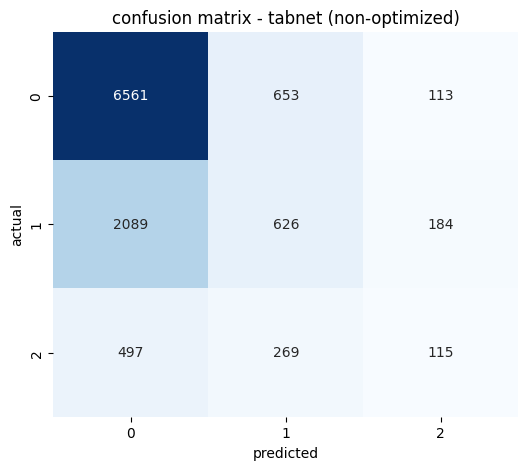

In [ ]:
# ----- user config -----
import pickle

device = "cuda" if __import__("torch").cuda.is_available() else "cpu"
random_state = 42
# tabnet_save_dir = "./tabnet_model_saved"
# os.makedirs(tabnet_save_dir, exist_ok=True)

# ----- convert to numpy arrays for TabNet -----
x_train_np = X_train.values.astype(np.float32)
y_train_np = y_train.values.astype(np.int64)
x_val_np = X_val.values.astype(np.float32)
y_val_np = y_val.values.astype(np.int64)
x_test_np = X_test.values.astype(np.float32)
y_test_np = y_test.values.astype(np.int64)

# ----- define TabNet with fixed/default parameters -----
final_model = TabNetClassifier(
    device_name=device,
    verbose=1,
    seed=random_state
    # You can manually set hyperparameters here if you want, 
    # e.g., n_d=16, n_a=16, n_steps=5, gamma=1.5, lambda_sparse=1e-4
)

# ----- train model -----
final_model.fit(
    x_train_np, y_train_np,
    eval_set=[(x_val_np, y_val_np)],
    patience=10,
    max_epochs=50,
    batch_size=512,
    virtual_batch_size=64
)

# ----- evaluation -----
y_pred = final_model.predict(x_test_np)
y_proba = final_model.predict_proba(x_test_np)

print("\nclassification report (test):")
print(classification_report(y_test_np, y_pred, digits=4))

metrics = {
    "accuracy": accuracy_score(y_test_np, y_pred),
    "precision_macro": precision_score(y_test_np, y_pred, average='macro', zero_division=0),
    "recall_macro": recall_score(y_test_np, y_pred, average='macro', zero_division=0),
    "f1_macro": f1_score(y_test_np, y_pred, average='macro', zero_division=0)
}

if y_proba is not None:
    try:
        if y_proba.shape[1] > 2:
            metrics["roc_auc"] = roc_auc_score(y_test_np, y_proba, multi_class='ovo', average='macro')
        else:
            metrics["roc_auc"] = roc_auc_score(y_test_np, y_proba[:, 1])
    except Exception:
        metrics["roc_auc"] = None

print("\nmetrics summary:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}" if v is not None else f"{k}: {v}")

# ----- confusion matrix -----
cm = confusion_matrix(y_test_np, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("confusion matrix - tabnet (non-optimized)")
plt.xlabel("predicted")
plt.ylabel("actual")
plt.show()

In [8]:
import lime 
import lime.lime_tabular
import matplotlib.pyplot as plt

plt.style.use('default')  # Use default style (white background)

# Set matplotlib to use white background globally
plt.style.use('classic')  # or 'classic'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Convert to numpy array if needed
X_test_array = X_test.values if isinstance(X_test, pd.DataFrame) else X_test

# Create LIME explainer with custom class names
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train.values, 
    mode='classification',
    feature_names=X_train.columns,
    class_names=['Normal', 'Diabetic'],
    discretize_continuous=True
)

# Get an explanation for a single prediction
observation_idx = 0
observation = pd.DataFrame(X_test_array, columns=X_test.columns).iloc[[observation_idx]]
explanation = explainer_lime.explain_instance(
    observation.values[0], 
    final_model.predict_proba,
    num_features=10
)

# Show LIME explanation with white background
explanation.show_in_notebook()

  0%|          | 0/100 [00:00<?, ?it/s]

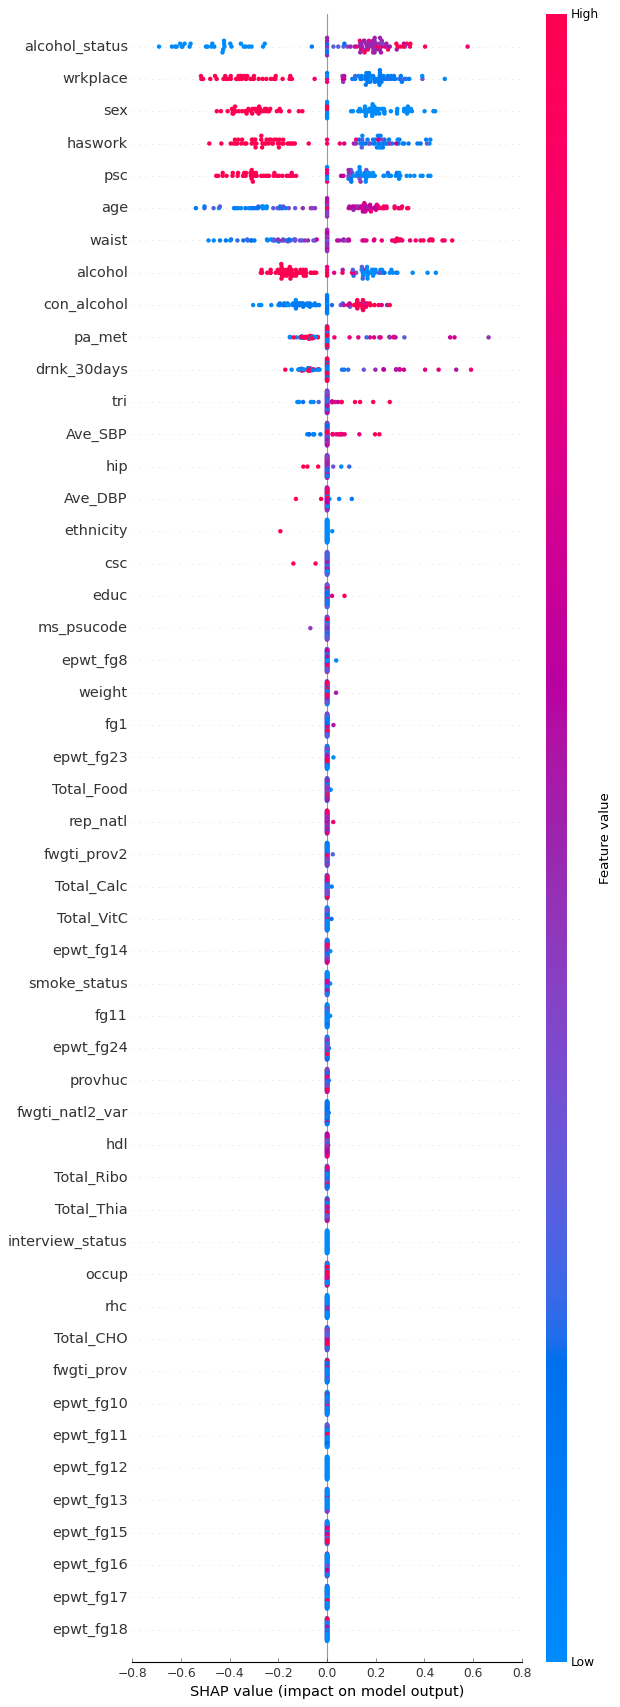

In [11]:
import shap

# Get subset
num_samples_subset = 100
np.random.seed(42)
subset_indices = np.random.choice(X_train.shape[0], num_samples_subset, replace=False)
X_train_subset = X_train.iloc[subset_indices]

# SHAP
explainer_shap = shap.KernelExplainer(final_model.predict, shap.sample(X_train_subset))

# SHAP Explanation
shap_values = explainer_shap.shap_values(X_train_subset)

#SHAP Summary Plot
shap.summary_plot(shap_values, X_train_subset, max_display=50)

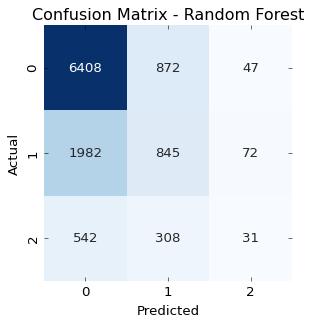


=== Random Forest ===
Validation accuracy: 0.6506
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.72      0.87      0.79      7327
           1       0.42      0.29      0.34      2899
           2       0.21      0.04      0.06       881

    accuracy                           0.66     11107
   macro avg       0.45      0.40      0.40     11107
weighted avg       0.60      0.66      0.61     11107

Test Accuracy: 0.6558
Precision: 0.5986
Recall: 0.6558
F1 Score: 0.6143
ROC AUC: 0.7008


In [12]:
# RF — Non-optimized
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_val_pred = rf_model.predict(X_val)
rf_val_accuracy = accuracy_score(y_val, rf_val_pred)
rf_test_pred = rf_model.predict(X_test)
rf_precision = precision_score(y_test, rf_test_pred, average='weighted')
rf_recall = recall_score(y_test, rf_test_pred, average='weighted')
rf_f1 = f1_score(y_test, rf_test_pred, average='weighted')
rf_y_prob = rf_model.predict_proba(X_test)
rf_roc_auc = roc_auc_score(y_test, rf_y_prob, multi_class='ovr')

rf_confusion_matrix = confusion_matrix(y_test, rf_test_pred)
plt.figure(figsize = (4,4))
sns.heatmap(rf_confusion_matrix, annot = True, fmt = "d", cmap = "Blues", cbar = False)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\n=== Random Forest ===")
print(f"Validation accuracy: {rf_val_accuracy:.4f}")
print("Classification Report for Random Forest:")
print(classification_report(y_test, rf_test_pred))
print(f"Test Accuracy: {accuracy_score(y_test, rf_test_pred):.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"F1 Score: {rf_f1:.4f}")
print(f"ROC AUC: {rf_roc_auc:.4f}")

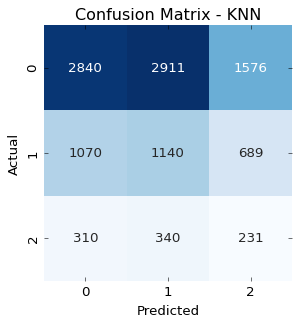


=== KNN ===
Validation accuracy: 0.3894
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.67      0.39      0.49      7327
           1       0.26      0.39      0.31      2899
           2       0.09      0.26      0.14       881

    accuracy                           0.38     11107
   macro avg       0.34      0.35      0.31     11107
weighted avg       0.52      0.38      0.42     11107

Test Accuracy: 0.3791
Precision: 0.5191
Recall: 0.3791
F1 Score: 0.4170
ROC AUC: 0.5191


In [13]:
# KNN — Non-optimized
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_val_pred = knn_model.predict(X_val)
knn_val_accuracy = accuracy_score(y_val, knn_val_pred)
knn_test_pred = knn_model.predict(X_test)
knn_precision = precision_score(y_test, knn_test_pred, average='weighted')
knn_recall = recall_score(y_test, knn_test_pred, average='weighted')
knn_f1 = f1_score(y_test, knn_test_pred, average='weighted')
knn_y_prob = knn_model.predict_proba(X_test)
knn_roc_auc = roc_auc_score(y_test, knn_y_prob, multi_class='ovr')

knn_confusion_matrix = confusion_matrix(y_test, knn_test_pred)
plt.figure(figsize = (4,4))
sns.heatmap(knn_confusion_matrix, annot = True, fmt = "d", cmap = "Blues", cbar = False)
plt.title("Confusion Matrix - KNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\n=== KNN ===")
print(f"Validation accuracy: {knn_val_accuracy:.4f}")
print("Classification Report for Random Forest:")
print(classification_report(y_test, knn_test_pred))
print(f"Test Accuracy: {accuracy_score(y_test, knn_test_pred):.4f}")
print(f"Precision: {knn_precision:.4f}")
print(f"Recall: {knn_recall:.4f}")
print(f"F1 Score: {knn_f1:.4f}")
print(f"ROC AUC: {knn_roc_auc:.4f}")

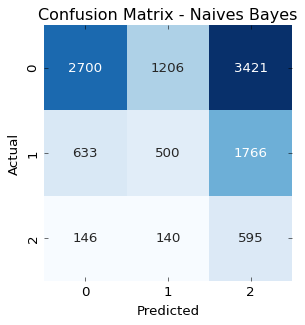


=== Naive Bayes ===
Validation accuracy: 0.3491
Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.78      0.37      0.50      7327
           1       0.27      0.17      0.21      2899
           2       0.10      0.68      0.18       881

    accuracy                           0.34     11107
   macro avg       0.38      0.41      0.30     11107
weighted avg       0.59      0.34      0.40     11107

Test Accuracy: 0.3417
Precision: 0.5908
Recall: 0.3417
F1 Score: 0.3988
ROC AUC: 0.5880


In [14]:
# Naive Bayes - Non-optimized
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_val_pred = nb_model.predict(X_val)
nb_val_accuracy = accuracy_score(y_val, nb_val_pred)
nb_test_pred = nb_model.predict(X_test)
nb_precision = precision_score(y_test, nb_test_pred, average='weighted')
nb_recall = recall_score(y_test, nb_test_pred, average='weighted')
nb_f1 = f1_score(y_test, nb_test_pred, average='weighted')
nb_y_prob = nb_model.predict_proba(X_test)
nb_roc_auc = roc_auc_score(y_test, nb_y_prob, multi_class='ovr')

nb_confusion_matrix = confusion_matrix(y_test, nb_test_pred)
plt.figure(figsize = (4,4))
sns.heatmap(nb_confusion_matrix, annot = True, fmt = "d", cmap = "Blues", cbar = False)
plt.title("Confusion Matrix - Naives Bayes")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\n=== Naive Bayes ===")
print(f"Validation accuracy: {nb_val_accuracy:.4f}")
print("Classification Report for Naive Bayes:")
print(classification_report(y_test, nb_test_pred))
print(f"Test Accuracy: {accuracy_score(y_test, nb_test_pred):.4f}")
print(f"Precision: {nb_precision:.4f}")
print(f"Recall: {nb_recall:.4f}")
print(f"F1 Score: {nb_f1:.4f}")
print(f"ROC AUC: {nb_roc_auc:.4f}")


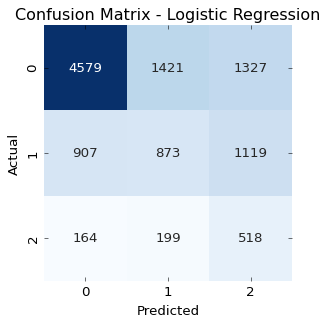


=== Logistic Regression ===
Validation accuracy: 0.5460
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.81      0.62      0.71      7327
           1       0.35      0.30      0.32      2899
           2       0.17      0.59      0.27       881

    accuracy                           0.54     11107
   macro avg       0.45      0.50      0.43     11107
weighted avg       0.64      0.54      0.57     11107

Test Accuracy: 0.5375
Precision: 0.6399
Recall: 0.5375
F1 Score: 0.5714
ROC AUC: 0.7033


In [15]:
# Logistic Regression - Non-optimized
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
lr_val_pred = lr_model.predict(X_val)
lr_val_accuracy = accuracy_score(y_val, lr_val_pred)
lr_test_pred = lr_model.predict(X_test)
lr_precision = precision_score(y_test,lr_test_pred, average='weighted')
lr_recall = recall_score(y_test, lr_test_pred, average='weighted')
lr_f1 = f1_score(y_test, lr_test_pred, average='weighted')
lr_y_prob = lr_model.predict_proba(X_test)
lr_roc_auc = roc_auc_score(y_test, lr_y_prob, multi_class='ovr')

lr_confusion_matrix = confusion_matrix(y_test, lr_test_pred)
plt.figure(figsize = (4,4))
sns.heatmap(lr_confusion_matrix, annot = True, fmt = "d", cmap = "Blues", cbar = False)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\n=== Logistic Regression ===")
print(f"Validation accuracy: {lr_val_accuracy:.4f}")
print("Classification Report for Logistic Regression:")
print(classification_report(y_test, lr_test_pred))
print(f"Test Accuracy: {accuracy_score(y_test, lr_test_pred):.4f}")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall: {lr_recall:.4f}")
print(f"F1 Score: {lr_f1:.4f}")
print(f"ROC AUC: {lr_roc_auc:.4f}")

In [ ]:

# SVM - Non-optimized
from sklearn.svm import SVC

svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train, y_train)
svm_val_pred = svm_model.predict(X_val)
svm_val_accuracy = accuracy_score(y_val, svm_val_pred)
svm_test_pred = svm_model.predict(X_test)
svm_precision = precision_score(y_test, svm_test_pred, average='weighted')
svm_recall = recall_score(y_test, svm_test_pred, average='weighted')
svm_f1 = f1_score(y_test, svm_test_pred, average='weighted')
svm_y_prob = svm_model.predict_proba(X_test)
svm_roc_auc = roc_auc_score(y_test, svm_y_prob, multi_class='ovr')

svm_confusion_matrix = confusion_matrix(y_test, svm_test_pred)
plt.figure(figsize = (4,4))
sns.heatmap(svm_confusion_matrix, annot = True, fmt = "d", cmap = "Blues", cbar = False)
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\n=== SVM ===")
print(f"Validation accuracy: {svm_val_accuracy:.4f}")
print("Classification Report for SVM:")
print(classification_report(y_test, svm_test_pred))
print(f"Test Accuracy: {accuracy_score(y_test, svm_test_pred):.4f}")
print(f"Precision: {svm_precision:.4f}")
print(f"Recall: {svm_recall:.4f}")
print(f"F1 Score: {svm_f1:.4f}")
print(f"ROC AUC: {svm_roc_auc:.4f}")

In [ ]:
# BO-TabNet - Optimized

# ----- user config -----
import os
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import warnings
from lime import lime_tabular
from lime.lime_tabular import LimeTabularExplainer
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import classification_report , confusion_matrix, accuracy_score , precision_score
from sklearn.metrics import recall_score, roc_auc_score, roc_curve, f1_score
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV

# Check if GPU is available
device = "cuda" if __import__("torch").cuda.is_available() else "cpu"
random_state = 42
tabnet_save_dir = "./tabnet_model_saved"
os.makedirs(tabnet_save_dir, exist_ok=True)

# ----- convert to numpy arrays for TabNet -----
x_train_np = X_train.values.astype(np.float32)
y_train_np = y_train.values.astype(np.int64)
x_val_np = X_val.values.astype(np.float32)
y_val_np = y_val.values.astype(np.int64)
x_test_np = X_test.values.astype(np.float32)
y_test_np = y_test.values.astype(np.int64)

# Define hyperparameter space for Bayesian optimization
param_space = {
    'n_d': (8, 64),  # Number of decision steps
    'n_a': (8, 64),  # Number of attention steps
    'n_steps': (5, 10),  # Number of steps in the network
    'gamma': (1.0, 2.0),  # Relaxation parameter
    'lambda_sparse': (1e-5, 1e-2),  # Sparsity regularization
}

# Define Bayesian optimization
def objective(params):
    model = TabNetClassifier(
        device_name=device,
        verbose=1,
        patience=10,
        seed=42,
        **params  # Unpack the parameters
    )
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
    y_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_pred)

    return -f1

# Perform Bayesian optimization
bayes_search = BayesSearchCV(
    TabNetClassifier(
        device_name=device,
        verbose=1,
        seed=random_state
    ),
    param_space,
    n_iter = 12,
    n_jobs = 4,
    scoring ='f1',
    cv = 10,
) 
bayes_search.fit(X_train.values, y_train)

# Get the best hyperparameters
best_params = bayes_search.best_params_
print("\nBest hyperparameters found:")

# Train TabNet with the best hyperparameters on training set
final_model = TabNetClassifier(
    device_name=device,
    verbose=1,
    **best_params  # Unpack the best parameters
)
final_model.fit(X_train.values, y_train)

# Loss History
plt.plot(final_model.hostory['loss'])

# Evaluate on Test Set
X_test_array = X_test.values if isinstance(X_test, pd.DataFrame) else X_test
y_test_pred = final_model.predict(X_test_array)
y_proba = final_model.predict_proba(X_test_array)

# Evaluate the model
print("Classification Report for BO-TabNet:")
print(classification_report(y_test, y_test_pred))

# Performance metrics
precision_tabnet = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
recall_tabnet = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
f1_tabnet = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
roc_auc_tabnet = roc_auc_score(y_test, y_proba, multi_class='ovr')

print(f"Precision: {precision_tabnet:.4f}")
print(f"Recall: {recall_tabnet:.4f}")
print(f"F1 Score: {f1_tabnet:.4f}")
print(f"ROC AUC: {roc_auc_tabnet:.4f}")

# Plot Confusion Matrix
cm_tabnet = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm_tabnet, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix - BO-TabNet")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# LIME Explanation
explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_train.values, mode='clasification',
    feature_names=X_train.columns)

# Get an explanation for a single prediction
observation_idx = 0
observation = pd.DataFrame(X_test_array, columns=X_test.columns).iloc[[observation_idx]]
explanation = explainer_lime.explain_instance(
    observation.values[0], 
    final_model.predict_proba,
)

# Show LIME explanation with white background
explanation.show_in_notebook()

# Save the final model
tabnet_model_path = './tabnet_model'
saved_filename = final_model.save_model(tabnet_model_path)